In [ ]:
from google.colab import drive
# Importanto as bibliotecas Python necessarias ao experimento
# Manipulacao matricial e visualizacao grafica
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [ ]:
drive.mount('/content/drive')

TARGET = "Diagnosis"

df = pd.read_csv("/content/drive/MyDrive/IA/wdbc.csv")
df = df.drop(columns=["ID"])
df[TARGET] = df[TARGET].replace(["M","B"], [1,0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ***Emsemble***
Para o emsemble, foram selecionados 4 técnicas de regressão:
*   **K-Nearest Neighbours**
*   **Decision Tree**
*   **Random Forest**
*   **Support Vector Machine**

Além disso, foi escolhido a ***Recall Score*** como métrica para quantificar a qualidade das predições de cada técnica aplicada. Após o cálculo dessas, foi adotada a ***Média Aritmética*** como métrica para avaliar a combinação dos modelos.

In [ ]:
# importando as técnicas de IA e a métrica de desempenho
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import recall_score

# divisão dos dados em treino e teste
from sklearn.model_selection import train_test_split

> ***Divisão dos dados***

>
70% dos dados foram destinados para ao conjunto de treinamento e os outros 30% para o conjunto de teste.

In [ ]:
# test: conjunto de teste
train, test = train_test_split(
    df, train_size=0.7, random_state=1, stratify=df[TARGET])

train1, train2 = train_test_split(
    train, train_size=0.5, random_state=1, stratify=train[TARGET])

# Conjunto de treinamento 1 e 2
df_split_train1, df_split_train2 = train_test_split(
    train1, train_size=0.5, random_state=1, stratify=train1[TARGET])

# Conjunto de treinamento 3 e 4
df_split_train3, df_split_train4 = train_test_split(
    train2, train_size=0.5, random_state=1, stratify=train2[TARGET])

print(f"+-----------------------------------------------+")
print(f"| Divisão dos dados\t\t\t\t|")
print(f"| Train1: {df_split_train1.shape}\t{df_split_train1[TARGET].value_counts()[1]/df_split_train1[TARGET].value_counts()[0]}\t|")
print(f"| Train2: {df_split_train2.shape}\t{df_split_train2[TARGET].value_counts()[1]/df_split_train2[TARGET].value_counts()[0]}\t|")
print(f"| Train3: {df_split_train3.shape}\t{df_split_train3[TARGET].value_counts()[1]/df_split_train3[TARGET].value_counts()[0]}\t|")
print(f"| Train4: {df_split_train4.shape}\t{df_split_train4[TARGET].value_counts()[1]/df_split_train4[TARGET].value_counts()[0]}\t|")
print(f"| Test: {test.shape}\t{test[TARGET].value_counts()[1]/test[TARGET].value_counts()[0]}\t|")
print(f"+-----------------------------------------------+")

+-----------------------------------------------+
| Divisão dos dados				|
| Train1: (99, 31)	0.5967741935483871	|
| Train2: (100, 31)	0.5873015873015873	|
| Train3: (99, 31)	0.5967741935483871	|
| Train4: (100, 31)	0.5873015873015873	|
| Test: (171, 31)	0.5981308411214953	|
+-----------------------------------------------+


Empacotamento dos 4 conjuntos de treinamento no DataFrame ***df_train***.
>
**OBS.:** cada linha *i* de ***df_train*** é composta por (atributos do conjunto *i*, target do conjunto *i*)

In [ ]:
df_train = pd.DataFrame([(df_split_train1.drop(columns=TARGET), df_split_train1[TARGET]),
                         (df_split_train2.drop(columns=TARGET), df_split_train2[TARGET]),
                         (df_split_train3.drop(columns=TARGET), df_split_train3[TARGET]),
                         (df_split_train4.drop(columns=TARGET), df_split_train4[TARGET])],
                        columns=["Features_train", "Target_train"])
df_train

,Features_train,Target_train
0,radius1 texture1 perimeter1 area1 sm...,89 0 366 1 98 0 23 1 295 0 ...
1,radius1 texture1 perimeter1 area1 sm...,353 1 180 1 183 0 367 0 454 0 ...
2,radius1 texture1 perimeter1 area1 sm...,140 0 75 1 234 0 44 1 382 0 ...
3,radius1 texture1 perimeter1 area1 sm...,337 1 516 1 388 0 243 0 110 0 ...


Empacotamento do conjunto de teste no DataFrame ***df_test***.
>
**OBS.:** a linha única de ***df_test*** é composta por (atributos do conjunto de teste, target do conjunto de teste)

In [ ]:
df_test = pd.DataFrame([(test.drop(columns=TARGET),test[TARGET])],
                       columns=["Features_test", "Target_test"])
df_test

,Features_test,Target_test
0,radius1 texture1 perimeter1 area1 sm...,399 0 16 1 369 1 174 0 71 0 ...


> ***Matriz de resultados***
>
***result_train***: cada linha i representa o vetor de médias ariméticas dos *MAPEs* calculados para o modelo i nos 4 conjuntos de treinamento para cada valor do hiperparâmetro.
>
***result_test***: cada linha i representa o vetor de médias ariméticas dos *MAPEs* calculados para o modelo i no conjunto de teste para cada valor do hiperparâmetro.

In [ ]:
result_train = pd.DataFrame(["-", "-", "-", "-"], index=["KNN", "DTREE", "RFRST", "SVM"],columns=["Recall Score"])

result_test = pd.DataFrame(["-", "-", "-", "-"], index=["KNN", "DTREE", "RFRST", "SVM"], columns=["Recall Score"])

# extração do conjunto de teste em features e target
features_test = df_test.iloc[0,0]
target_test = df_test.iloc[0,1]

> ***classification(func)***
>
Função que decora a técnica de IA passada por argumento

> ***train_and_test(features_train, target_train, *args, **kwargs)***

Função que treina e testa o modelo, dado:
*   **features_train**: conjunto de features para o treinamento
*   **target_train**: target para o trainamento treinamento
*   **kwargs**: deve, ***obrigatoriamente***, passar o key_word do hiperparâmetro do modelo como primeiro elemento

***return***: uma tupla contendo os *Recall Scores* de treinamento e de teste para um modelo específico



In [ ]:
def classification(func):
  def train_and_test(features_train, target_train, *args, **kwargs):
    f = func(*args, **kwargs)

    f.fit(features_train, target_train)
    target_prediction_train = f.predict(features_train)
    target_prediction_test = f.predict(features_test)

    # calculos dos recall score para o conjunto treinado e testado
    f_error_train = recall_score(target_train, target_prediction_train)
    f_error_test = recall_score(target_test, target_prediction_test)

    return f_error_train, f_error_test

  return train_and_test

# inicialização dos modelos inteligentes
knn = classification(KNeighborsClassifier)
dtree = classification(DecisionTreeClassifier)
rfrst = classification(RandomForestClassifier)
svm = classification(SVC)

> ***train_and_test_4_sets(*, algorithm, hyperp_start, step=1, **kwargs)***
>
Função que treina e testa o modelo para todos os 4 conjuntos de treinamento, dado:
*   **algorithm**: técnica de IA a ser utilizada
*   **hyperp_start**: o hiperparâmetro inicial
*   **step**: incremento do hiperparâmetro a cada iteração
*   **kwargs**: deve, ***obrigatoriamente***, passar o key_word do hiperparâmetro do modelo como primeiro elemento

***return***: uma tupla contendo as matrizes dos 4 conjuntos treinados e testados para o modelo passado


In [ ]:
def train_and_test_4_sets(*, algorithm, hyperp_start, step=1, **kwargs):
  trained = pd.DataFrame()
  trained.index = np.arange(hyperp_start,hyperp_start+15*step, step)

  tested = pd.DataFrame()
  tested.index = np.arange(hyperp_start,hyperp_start+15*step, step)

  for i in np.arange(4):
    # conjunto de treino i separado em features e target
    features_train = df_train.iloc[i, 0]
    target_train = df_train.iloc[i, 1]

    # armazena os Recall Scores do modelo para o conjunto i
    f_result_train = []
    f_result_test = []

    for h in np.arange(hyperp_start,hyperp_start+15*step, step):
      hyperp = list(kwargs.keys())[0]
      kwargs[hyperp] = h

      f_result = algorithm(features_train, target_train, **kwargs)
      f_result_train.append(f_result[0])
      f_result_test.append(f_result[1])

    trained[f"{i+1}"], tested[f"{i+1}"] = f_result_train, f_result_test

  return trained, tested

> ***plot_sets(trained_set, tested_set, title)***
>
Função que plota os conjuntos treinados e testados de acordo com os valores de seus hiperparâmetros
*   **trained_set**: conjunto treinado
*   **tested_set**: conjunto testado
*   **title**: nome da técnica

In [ ]:
def plot_sets(trained_set, tested_set, title):
  figure, axis = plt.subplots(1,2)
  figure.set_figwidth(20)

  # plot do conjunto treinado
  axis[0].plot(trained_set.index, trained_set.iloc[:,0], color='#FF1E1E', label="1")
  axis[0].plot(trained_set.index, trained_set.iloc[:,1], color='#3B44F6', label="2")
  axis[0].plot(trained_set.index, trained_set.iloc[:,2], color='#16FF00', label="3")
  axis[0].plot(trained_set.index, trained_set.iloc[:,3], color='#FFED00', label="4")
  axis[0].set_title(f"{title} Train")
  axis[0].legend()

  # plot do conjunto testado
  axis[1].plot(tested_set.index, tested_set.iloc[:,0], color='#FF1E1E', label="1")
  axis[1].plot(tested_set.index, tested_set.iloc[:,1], color='#3B44F6', label="2")
  axis[1].plot(tested_set.index, tested_set.iloc[:,2], color='#16FF00', label="3")
  axis[1].plot(tested_set.index, tested_set.iloc[:,3], color='#FFED00', label="4")
  axis[1].set_title(f"{title} Test")
  axis[1].legend()

  plt.show()

> ***K-Nearest Neighbours(KNN)***
>
Algoritmo KNN aplicado aos 4 conjuntos de treinamento, utilizando um número de vizinhos ***k=2*** como hiperparâmetro inicial e métrica de distância euclidiana.

In [ ]:
trained, tested = train_and_test_4_sets(algorithm=knn, hyperp_start=5, n_neighbors=None, metric="euclidean")
tested

,1,2,3,4
5,0.796875,0.812500,0.843750,0.812500
6,0.750000,0.781250,0.781250,0.781250
7,0.750000,0.812500,0.796875,0.796875
8,0.750000,0.765625,0.781250,0.781250
9,0.765625,0.781250,0.781250,0.781250
10,0.765625,0.765625,0.765625,0.781250
11,0.765625,0.765625,0.796875,0.796875
12,0.765625,0.765625,0.734375,0.765625
13,0.765625,0.765625,0.765625,0.765625
14,0.765625,0.734375,0.734375,0.765625


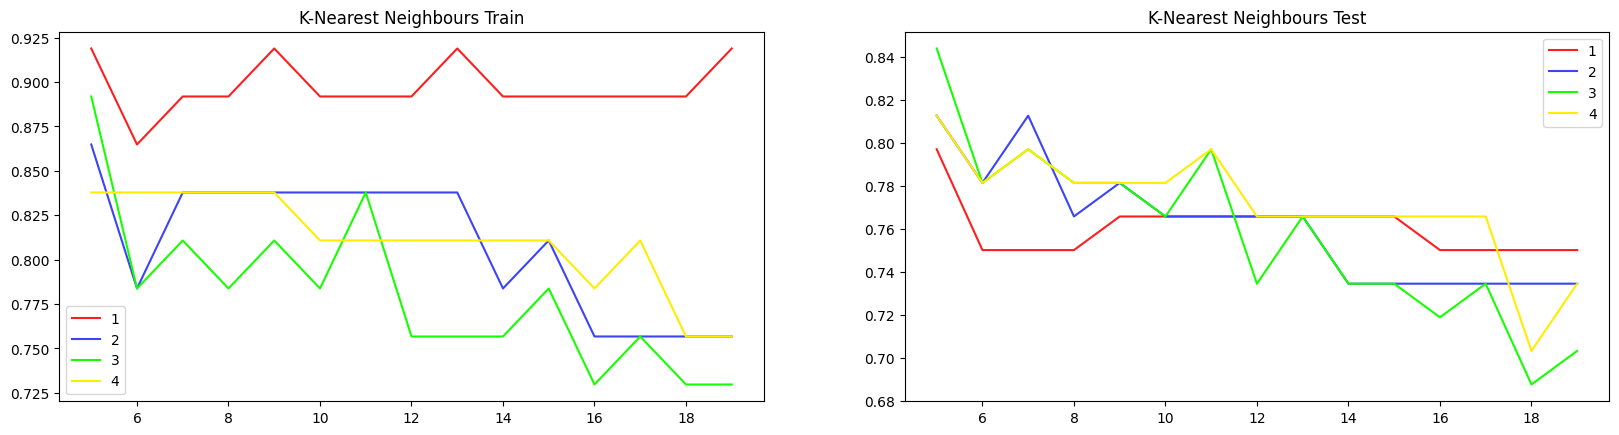

In [ ]:
# plot do KNN de treino e teste para todos os hiperparâmetros
plot_sets(trained, tested, title="K-Nearest Neighbours")

In [ ]:
# média aritmética dos MAPEs dos 4 conjuntos para o hiperparâmetro i
trained = pd.DataFrame(trained.mean(axis=1))
tested = pd.DataFrame(tested.mean(axis=1))

# armazenando o vetor de médias dos MAPEs na linha correspondente ao KNN
result_train.iloc[0,0] = trained
result_test.iloc[0,0] = tested

result_test

,Recall Score
KNN,0 5 0.816406 6 0.773438 7 0.7...
DTREE,-
RFRST,-
SVM,-


In [ ]:
print(f"Recall Score Médio = {pd.DataFrame(tested.mean(axis=0)).iloc[0,0]}")

Recall Score Médio = 0.7625


> ***Decision Tree***
>
Algoritmo da Árvore de Decisão aplicado aos 4 conjuntos de treinamento, utilizando um mínimo de observações ***n=5*** como hiperparâmetro inicial.

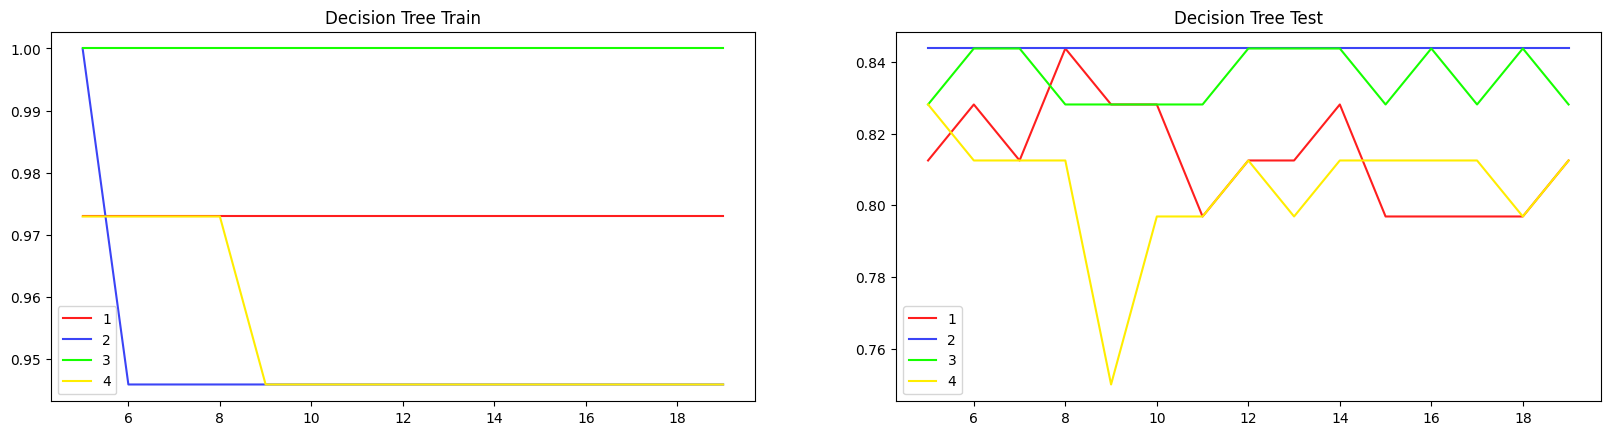

In [ ]:
trained, tested = train_and_test_4_sets(algorithm=dtree, hyperp_start=5, min_samples_split=None)

plot_sets(trained, tested, title="Decision Tree")

trained = pd.DataFrame(trained.mean(axis=1))
tested = pd.DataFrame(tested.mean(axis=1))

result_train.iloc[1,0] = trained
result_test.iloc[1,0] = tested

> ***Random Forest***
>
Algoritmo da Floresta Aleatória aplicado aos 4 conjuntos de treinamento, utilizando um número de árvores ***n=2*** como hiperparâmetro inicial.

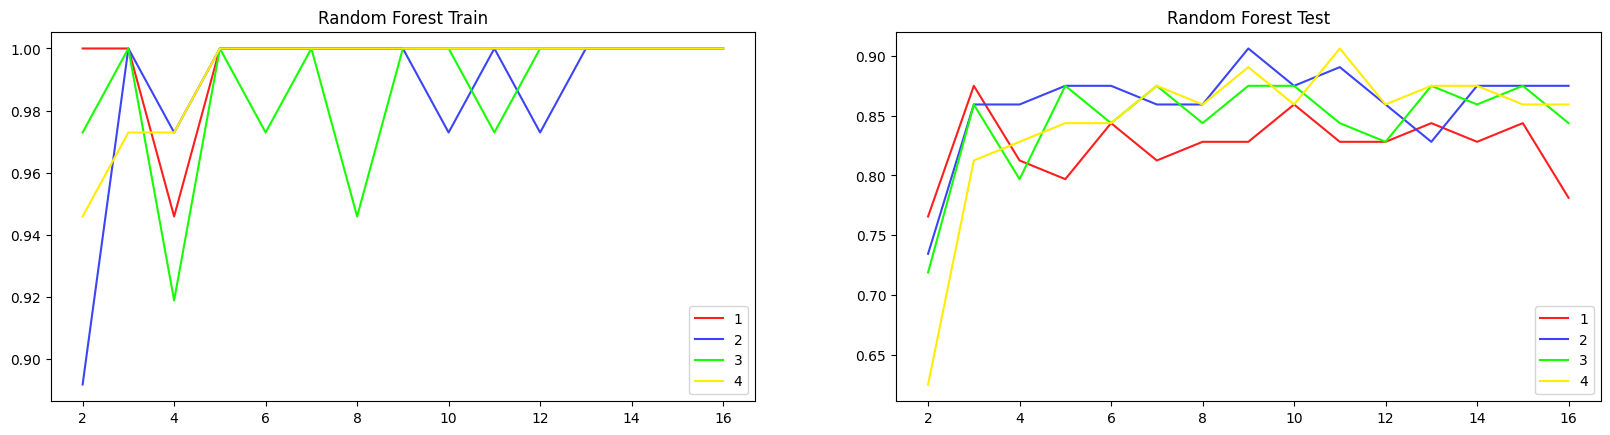

In [ ]:
trained, tested = train_and_test_4_sets(algorithm=rfrst, hyperp_start=2, n_estimators=None, n_jobs=-1)

plot_sets(trained, tested, title="Random Forest")

trained = pd.DataFrame(trained.mean(axis=1))
tested = pd.DataFrame(tested.mean(axis=1))

result_train.iloc[2,0] = trained
result_test.iloc[2,0] = tested

> ***Support Vector Machine(SVM)***
>
Algoritmo SVM aplicado aos 4 conjuntos de treinamento, utilizando uma tolerância ***n=2*** como hiperparâmetro inicial e incremento de 0.1 e transformação dos dados ***kernel="linear"***.

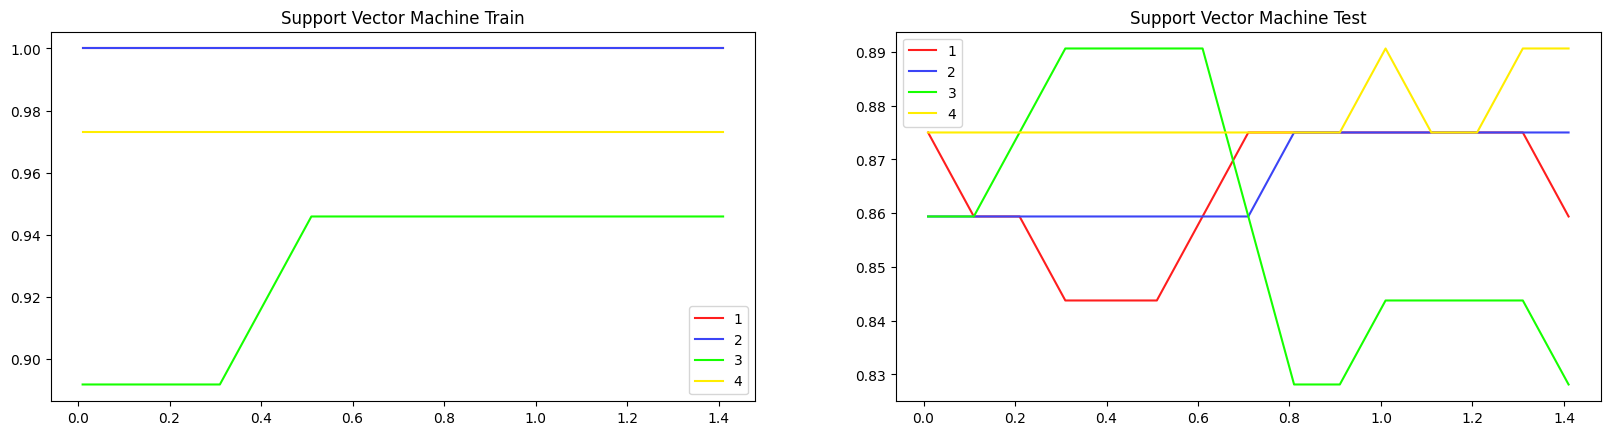

In [ ]:
trained, tested = train_and_test_4_sets(algorithm=svm, hyperp_start=0.01, step=0.1, tol=None, kernel="linear", C=1, cache_size=100)

plot_sets(trained, tested, title="Support Vector Machine")

trained = pd.DataFrame(trained.mean(axis=1))
tested = pd.DataFrame(tested.mean(axis=1))

result_train.iloc[3,0] = trained
result_test.iloc[3,0] = tested

In [ ]:
# o vetor de médias contendo 4 x 15 = 60 resultados
result_test

,Recall Score
KNN,0 5 0.816406 6 0.773438 7 0.7...
DTREE,0 5 0.828125 6 0.832031 7 0.8...
RFRST,0 2 0.710938 3 0.851562 4 0.8...
SVM,0 0.01 0.867188 0.11 0.863281 0...


> ***10% de 240 = 24 melhores***

In [ ]:
# armazena os 60 resultados em um DataFrame com colunas autoexplicativas
result_train = pd.DataFrame([(result_train.index[a], "{:.2f}".format(result_train.iloc[a,0].index[i]), result_train.iloc[a,0].iloc[i,0]) for i in range(15) for a in range(4)],
                           columns=["Modelo", "Hyperparameter", "MAPE"])

# ordena com base nos "MAPEs"
result_train = result_train.sort_values(by="MAPE", ascending=False).reset_index(drop=True)

# seleciona os 10% melhores de 240 resultados
result_train.iloc[:round(0.1*240), :]

,Modelo,Hyperparameter,MAPE
0,RFRST,9.00,1.000000
1,RFRST,14.00,1.000000
2,RFRST,5.00,1.000000
3,RFRST,13.00,1.000000
4,RFRST,7.00,1.000000
5,RFRST,16.00,1.000000
6,RFRST,15.00,1.000000
7,RFRST,11.00,0.993243
8,RFRST,6.00,0.993243
9,RFRST,10.00,0.993243


In [ ]:
# armazena os 60 resultados em um DataFrame com colunas autoexplicativas
result_test = pd.DataFrame([(result_test.index[a], "{:.2f}".format(result_test.iloc[a,0].index[i]), result_test.iloc[a,0].iloc[i,0]) for i in range(15) for a in range(4)],
                           columns=["Modelo", "Hyperparameter", "MAPE"])

# ordena com base nos "MAPEs"
result_test = result_test.sort_values(by="MAPE", ascending=False).reset_index(drop=True)

# seleciona os 10% melhores de 240 resultados = 24
result_test.iloc[:round(0.1*240), :]

,Modelo,Hyperparameter,MAPE
0,RFRST,9.00,0.875000
1,SVM,1.31,0.871094
2,SVM,0.61,0.871094
3,SVM,1.01,0.871094
4,RFRST,11.00,0.867188
5,SVM,0.31,0.867188
6,SVM,0.71,0.867188
7,RFRST,10.00,0.867188
8,SVM,0.21,0.867188
9,SVM,0.51,0.867188
